# Mean results plot
Simple notebook to plot figures for the paper.

Authors:
Edoardo Daniele Cannas - edoardodaniele.cannas@polimi.it  
Sriram Baireddy - sbairedd@purdue.edu  
Paolo Bestagini - paolo.bestagini@polimi.it  
Stefano Tubaro - stefano.tubaro@polimi.it  
Edward J. Delp - ace@purdue.edu  

## Libraries import

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob
import cv2
from sklearn.metrics import roc_curve, auc
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Times New Roman']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

## Helpers

In [2]:
from sklearn.preprocessing import RobustScaler, QuantileTransformer

def quantile_scaling(img: np.ndarray, dist: str) -> np.ndarray:
	"""
	QuantileTransformer: maps the image range to a specific stastical distribution
	
	:param img: np.ndarray, input image (tested GRD 16-bits)
	:param distribution: str, distribution for mapping the image (either 'uniform' or 'normal')
	:return: np.ndarray, normalized numpy array
	"""
	return QuantileTransformer(output_distribution=dist).fit_transform(img.reshape(-1, 1)).reshape(img.shape)


def rename_sat(product: str) -> str:
    if product[0] == 'L':
        sat_name = 'Landsat8'
    else:
        sat_name = product.split('_')[0]
        if sat_name in ['AMAZONIA', 'CBERS']:
            sat_name += f'{product.split("_")[1]}_{product.split("_")[2]}'
    return sat_name


def compute_model_sign(train_tag: str) -> str:
    # Create a tag for the visualization
    model_sign = train_tag.split('/')[-3]
    return model_sign
        

In [3]:
%%javascript
(function(on) {
const e=$( "<a>Setup failed</a>" );
const ns="js_jupyter_suppress_warnings";
var cssrules=$("#"+ns);
if(!cssrules.length) cssrules = $("<style id='"+ns+"' type='text/css'>div.output_stderr { } </style>").appendTo("head");
e.click(function() {
    var s='Showing';  
    cssrules.empty()
    if(on) {
        s='Hiding';
        cssrules.append("div.output_stderr, div[data-mime-type*='.stderr'] { display:none; }");
    }
    e.text(s+' warnings (click to toggle)');
    on=!on;
}).click();
$(element).append(e);
})(true);

<IPython.core.display.Javascript object>

## Load the results

### Histogram Equalization Generated Dataset (HEGD)

In [5]:
# Look for all models used
results_dir = '../results/hegd'  # PLACE YOUR RESULTS DIRECTORY HERE!
all_dfs_paths = glob.glob(os.path.join(results_dir, '**', 'results_df_mean_fingerprints.pkl'), recursive=True)

# Load the Dataframe for each model and put it in a bigger one
all_results_df = []
for path in all_dfs_paths:
    # Load results
    df = pd.read_pickle(path)
    # Create a tag for the visualization
    model_sign = compute_model_sign(path)
    # Save in the bigger DataFrame
    df = pd.concat({model_sign: df}, names=['Model_name', 'Operation', 'Img_idx'])
    all_results_df.append(df)

# Concatenate everything
all_results_df = pd.concat(all_results_df)

# Compute the mean across operations
he_mean_results = all_results_df.groupby(['Model_name', 'Operation']).mean()[['AUC']]


/tmp/ipykernel_451295/1282501006.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  he_mean_results = all_results_df.groupby(['Model_name', 'Operation']).mean()[['AUC']]


### Standard Generated Dataset (SGD)

In [6]:
# Look for all models used
results_dir = '../results/sgd'  # PLACE YOUR RESULTS DIRECTORY HERE!
all_dfs_paths = glob.glob(os.path.join(results_dir, '**', 'results_df_mean_fingerprints.pkl'), recursive=True)

# Load the Dataframe for each model and put it in a bigger one
all_results_df = []
for path in all_dfs_paths:
    # Load results
    df = pd.read_pickle(path)
    # Create a tag for the visualization
    model_sign = compute_model_sign(path)
    # Save in the bigger DataFrame
    df = pd.concat({model_sign: df}, names=['Model_name', 'Operation', 'Img_idx'])
    all_results_df.append(df)

# Concatenate everything
all_results_df = pd.concat(all_results_df)

# Compute the mean across operations
max_abs_mean_results = all_results_df.groupby(['Model_name', 'Operation']).mean()[['AUC']]


/tmp/ipykernel_451295/3642307309.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  max_abs_mean_results = all_results_df.groupby(['Model_name', 'Operation']).mean()[['AUC']]


### Join together the Dataframes

In [7]:
all_results = max_abs_mean_results.join(he_mean_results, rsuffix=' HEG', lsuffix=' SG')
all_results

AUC SG   AUC HEG
Model_name            Operation                                      
HistogramEqualization UnnamedAffine                0.756331  0.763947
                      UnnamedAverageBlur           0.744204  0.742003
                      UnnamedGaussianBlur          0.758412  0.750998
                      UnnamedIdentity              0.760556  0.783793
                      UnnamedLogContrast           0.772095  0.768795
                      UnnamedMotionBlur            0.757253  0.769163
                      UnnamedPerspectiveTransform  0.761552  0.764107
                      UnnamedPiecewiseAffine       0.763977  0.766819
                      UnnamedSigmoidContrast       0.761040  0.777605
MaxScaling            UnnamedAffine                0.742213  0.752721
                      UnnamedAverageBlur           0.757626  0.728235
                      UnnamedGaussianBlur          0.749822  0.741118
                      UnnamedIdentity              0.770409  0.771507
                      UnnamedLogContrast           0.763800  0.771489
                      UnnamedMotionBlur            0.756712  0.738521
                      UnnamedPerspectiveTransform  0.750572  0.750220
                      UnnamedPiecewiseAffine       0.742307  0.752633
                      UnnamedSigmoidContrast       0.772171  0.772049
MinPMax_95            UnnamedAffine                0.878123  0.726338
                      UnnamedAverageBlur           0.894674  0.726864
                      UnnamedGaussianBlur          0.890287  0.729464
                      UnnamedIdentity              0.883864  0.725904
                      UnnamedLogContrast           0.903303  0.732466
                      UnnamedMotionBlur            0.883550  0.734275
                      UnnamedPerspectiveTransform  0.885665  0.732015
                      UnnamedPiecewiseAffine       0.890646  0.727450
                      UnnamedSigmoidContrast       0.925032  0.754774
MinPMax_99            UnnamedAffine                0.858914  0.636660
                      UnnamedAverageBlur           0.879219  0.638835
                      UnnamedGaussianBlur          0.872064  0.637977
                      UnnamedIdentity              0.864366  0.627199
                      UnnamedLogContrast           0.871211  0.649995
                      UnnamedMotionBlur            0.869927  0.627036
                      UnnamedPerspectiveTransform  0.872449  0.632484
                      UnnamedPiecewiseAffine       0.878822  0.631335
                      UnnamedSigmoidContrast       0.896265  0.660360

## Plot the results
We are going to have a separate bar plot for the SGD and the HEGD datasets.

### Re-organize the Dataframe

In [8]:
# Select the models to plot
plot_df = all_results.loc[['MinPMax_95', 'MinPMax_99', 'MaxScaling', 'HistogramEqualization']]
# Rename the columns
plot_df = plot_df.rename({'MinPMax_95': r'MinPMax $95^{th}$ percentile',
                          'MinPMax_99': r'MinPMax $99^{th}$ percentile',
                          'MaxScaling': r'MaxScaling',
                          'HistogramEqualization': 'HistogramEqualization'})
# Rename the index
plot_df = plot_df.rename_axis(index={'Model_name': 'Preprocessing strategy'})
# Rename the operations
operations_mapping = {'Affine': 'Rotation + resize', 'AverageBlur': 'Average blur', 'GaussianBlur': 'Gaussian Blur',
                      'Identity': 'No editing', 'LogContrast': 'Log contrast', 'MotionBlur': 'Motion blur',
                      'PerspectiveTransform': 'Prospective affine', 'PiecewiseAffine': 'Piecewise affine', 
                      'SigmoidContrast': 'Sigmoid contrast'}
plot_df.index = plot_df.index.set_levels([plot_df.index.levels[0], plot_df.index.levels[1].map(lambda x: operations_mapping[x.replace('Unnamed', '')])])
plot_df = plot_df.sort_index()
plot_df


AUC SG   AUC HEG
Preprocessing strategy       Operation                             
HistogramEqualization        Average blur        0.744204  0.742003
                             Gaussian Blur       0.758412  0.750998
                             Log contrast        0.772095  0.768795
                             Motion blur         0.757253  0.769163
                             No editing          0.760556  0.783793
                             Piecewise affine    0.763977  0.766819
                             Prospective affine  0.761552  0.764107
                             Rotation + resize   0.756331  0.763947
                             Sigmoid contrast    0.761040  0.777605
MaxScaling                   Average blur        0.757626  0.728235
                             Gaussian Blur       0.749822  0.741118
                             Log contrast        0.763800  0.771489
                             Motion blur         0.756712  0.738521
                             No editing          0.770409  0.771507
                             Piecewise affine    0.742307  0.752633
                             Prospective affine  0.750572  0.750220
                             Rotation + resize   0.742213  0.752721
                             Sigmoid contrast    0.772171  0.772049
MinPMax $95^{th}$ percentile Average blur        0.894674  0.726864
                             Gaussian Blur       0.890287  0.729464
                             Log contrast        0.903303  0.732466
                             Motion blur         0.883550  0.734275
                             No editing          0.883864  0.725904
                             Piecewise affine    0.890646  0.727450
                             Prospective affine  0.885665  0.732015
                             Rotation + resize   0.878123  0.726338
                             Sigmoid contrast    0.925032  0.754774
MinPMax $99^{th}$ percentile Average blur        0.879219  0.638835
                             Gaussian Blur       0.872064  0.637977
                             Log contrast        0.871211  0.649995
                             Motion blur         0.869927  0.627036
                             No editing          0.864366  0.627199
                             Piecewise affine    0.878822  0.631335
                             Prospective affine  0.872449  0.632484
                             Rotation + resize   0.858914  0.636660
                             Sigmoid contrast    0.896265  0.660360

### Plot the SGD results

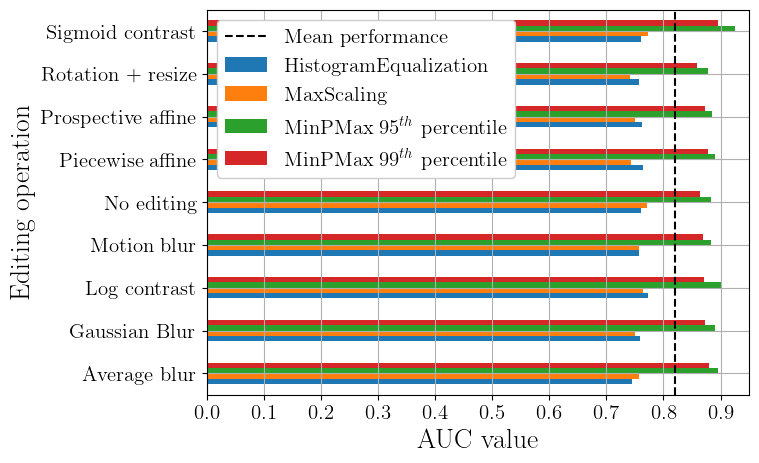

In [9]:
# Plot params
plt.rcParams['font.family'] = 'Times New Roman'
fontsize=20
ax = plot_df['AUC SG'].swaplevel(0, 1).unstack(level=1).plot.barh(legend=True, 
                                                                 xlim=[0, 0.95], 
                                                                 xticks=np.linspace(0, 1.0, 11), 
                                                                 grid=True, figsize=(7, 5))

# Adjust the layout
ax.tick_params(axis='both', labelsize=fontsize-5)
ax.set_ylabel('Editing operation', fontsize=fontsize)
ax.set_xlabel('AUC value', fontsize=fontsize)
ax.axvline(x=plot_df['AUC SG'].mean(), color='black', linestyle='--', label='Mean performance')
legend = ax.legend(loc='upper left', prop={'size': fontsize-5})
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(1)


### Plot the HEGD results

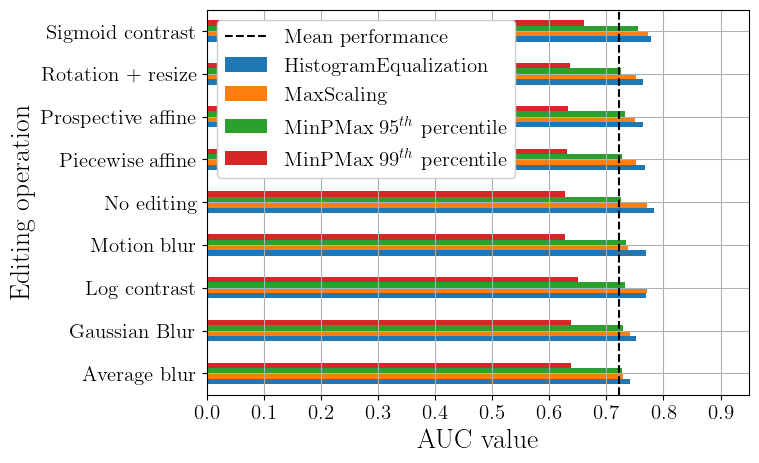

In [10]:
# Plot params
plt.rcParams['font.family'] = 'Times New Roman'
fontsize=20
ax = plot_df['AUC HEG'].swaplevel(0, 1).unstack(level=1).plot.barh(legend=True, 
                                                                 xlim=[0, 0.95], 
                                                                 xticks=np.linspace(0, 1.0, 11), 
                                                                 grid=True, figsize=(7, 5))

# Adjust the layout
ax.tick_params(axis='both', labelsize=fontsize-5)
ax.set_ylabel('Editing operation', fontsize=fontsize)
ax.set_xlabel('AUC value', fontsize=fontsize)
ax.axvline(x=plot_df['AUC HEG'].mean(), color='black', linestyle='--', label='Mean performance')
legend = ax.legend(loc='upper left', prop={'size': fontsize-5})
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(1)
